In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
%matplotlib inline

In [2]:
# all data folders
all_folders = [folder for folder in os.listdir() if folder.startswith("long_1") or folder.startswith("long_2")]
all_folders

['long_1499',
 'long_1551',
 'long_1551_2',
 'long_1551_3',
 'long_1599',
 'long_1649',
 'long_1699',
 'long_1750',
 'long_2001']

In [8]:
all_folders = ['long_1551',
 'long_1551_3',
 'long_1551_2']

In [4]:
%%time
datafolder = "long_1599/"
raw_data=[]
for file in os.listdir(datafolder)[:4]:
    data = ""
    with open(f"{datafolder}{file}","r") as f:
        data = f.readlines()
    raw_data.append( [int(d.split(",")[0]) for d in data[25:]] )
raw_data = np.array(raw_data)

Wall time: 37.6 ms


In [5]:
header = data[:25]
header

['Format,1.0B,\n',
 'Memory Length,10000,\n',
 'IntpDistance,0,\n',
 'Trigger Address,4849,\n',
 'Trigger Level,8.000E-01,\n',
 'Source,CH1,\n',
 'Vertical Units,V,\n',
 'Vertical Units Div,0,\n',
 'Vertical Units Extend Div,16,\n',
 'Label,,\n',
 'Probe Type,0,\n',
 'Probe Ratio,1.000e+01,\n',
 'Vertical Scale,2.000e-01,\n',
 'Vertical Position,-6.800e-01,\n',
 'Horizontal Units,S,\n',
 'Horizontal Scale,2.000E-06,\n',
 'Horizontal Position,3.000E-07,\n',
 'Horizontal Mode,Main,\n',
 'SincET Mode,Real Time,\n',
 'Sampling Period,2.000e-09,\n',
 'Horizontal Old Scale,2.000E-06,\n',
 'Horizontal Old Position,3.000E-07,\n',
 'Firmware,V1.23,\n',
 'Mode,Fast,\n',
 'Waveform Data,\n']

In [6]:
scope_settings = [d[:-2] for i,d in list(enumerate(data)) if i in [4,12,13,15,19]]
print(scope_settings)
trigger_level = float(data[4].split(",")[1])
vert_scale = float(data[12].split(",")[1])
vert_pos = float(data[13].split(",")[1])
trigger_level,vert_scale,vert_pos,np.max(raw_data),np.min(raw_data)

['Trigger Level,8.000E-01', 'Vertical Scale,2.000e-01', 'Vertical Position,-6.800e-01', 'Horizontal Scale,2.000E-06', 'Sampling Period,2.000e-09']


(0.8, 0.2, -0.68, 125, -2)

# how does `trigger level`, `input voltage` affect the distribution of peaks?

In [15]:
%%time
raw_data_list = []
for i,datafolder in enumerate(all_folders):
    raw_data=[]
    for file in os.listdir(datafolder)[:1000]:
        data = ""
        with open(f"{datafolder}/{file}","r") as f:
            data = f.readlines()
        raw_data.append( [int(d.split(",")[0]) for d in data[25:]] )
    raw_data = np.array(raw_data)
    raw_data_list.append( (datafolder,raw_data,data) )
print("done reading data")

done reading data
Wall time: 28.4 s


In [18]:
def get_scopesettings(data):
    scope_settings = [d[:-2] for i,d in list(enumerate(data)) if i in [4,12,13,15,19]]
    trigger_level = float(data[4].split(",")[1])
    vert_scale = float(data[12].split(",")[1])
    vert_pos = float(data[13].split(",")[1])
    return scope_settings,trigger_level,vert_scale,vert_pos

Wall time: 4.78 s


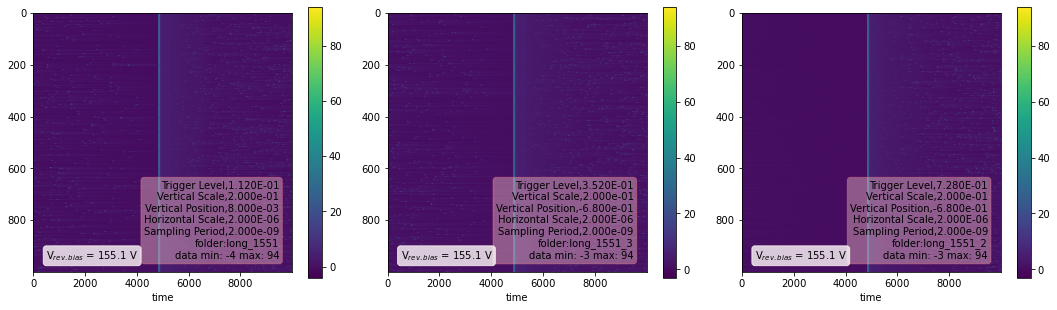

In [19]:
%%time
fig,axx = plt.subplots(1,3,figsize=(15,5))
axx=axx.ravel()
for i,_ in enumerate(all_folders):
    ax=axx[i]
    datafolder, raw_data,data = raw_data_list[i]
    scope_settings,trigger_level,vert_scale,vert_pos = get_scopesettings(data)
    im = ax.imshow(np.array(raw_data),interpolation=None,aspect=10)
    plt.colorbar(im,ax=ax,shrink=0.8)
    ax.text(0.95,0.05,"\n".join(scope_settings)+"\nfolder:"+datafolder+
            f"\ndata min: {np.min(raw_data)} max: {np.max(raw_data)}",
            fontsize=10,ha="right", transform=ax.transAxes,
            bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5,0.4), fc=(1., 0.8, 0.8,0.4)))
    ax.text(0.05,0.05,r"V$_{rev. bias}$ = "+f"{float(datafolder[5:9])/10:.1f} V",
            fontsize=10,ha="left", transform=ax.transAxes,
            bbox=dict(boxstyle="round", ec=(1., 0.95, 0.95,0.8), fc=(1., 0.98, 0.98,0.8)))
    ax.set_xlabel("time")
plt.tight_layout()
plt.savefig("results02_comparing_triggerlevel_voltage.png",dpi=100)

Wall time: 43.1 s


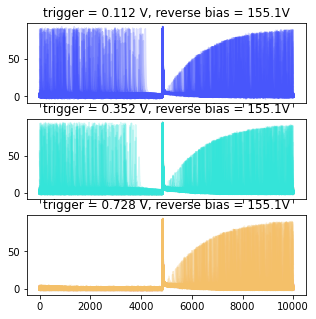

In [39]:
%%time
fig,axx = plt.subplots(3,1,sharex=True,figsize=(5,5))
for i,_ in enumerate(all_folders):
    ax=axx[i]
    datafolder, raw_data,data = raw_data_list[i]
    scope_settings,trigger_level,vert_scale,vert_pos = get_scopesettings(data)
    ax.plot(raw_data[:1000].T,c=plt.cm.rainbow(trigger_level),alpha=0.2)
    ax.set_title(f"trigger = {trigger_level} V, reverse bias = 155.1V")
plt.savefig("results02_triggerlevel.png")

### average time before each trigger

In [41]:
i=0
datafolder, raw_data,data = raw_data_list[i]
scope_settings,trigger_level,vert_scale,vert_pos = get_scopesettings(data)

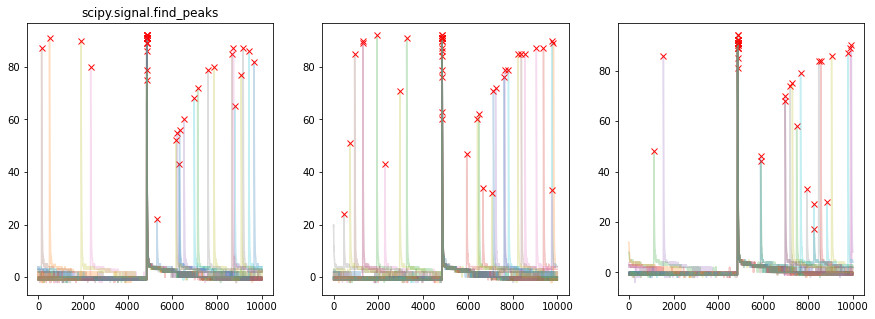

In [85]:
from scipy.signal import find_peaks

fig,axx = plt.subplots(1,3,figsize=(15,5))
for plot_i,ax in enumerate(axx):
    for i in range(60+plot_i*20,80+plot_i*20):
        peak_x , peak_heights = find_peaks(raw_data[i],height=10,width=10)
        ax.plot(raw_data[i],alpha=0.26)
        ax.plot(peak_x,peak_heights["peak_heights"],"x",c="r",alpha=0.96)
axx[0].set_title("scipy.signal.find_peaks")
plt.savefig("results02_peakfinding_success.png")

## todo, find the time intervals between peaks

notes:

multimeter readings 

1.6 1.4 micro amp

voltage +2.448 -1.258

generator:

1.855vpp

300mv offset